創建資料夾儲存結果

In [21]:
import torch
import os
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

import datetime
date_string = str(datetime.date.today())
print(date_string)

dir_name = "./" + date_string + "_result/"
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)
else:
    print(dir_name + "is exist")

print(dir_name)

True
NVIDIA GeForce GTX 1660
2023-08-16
./2023-08-16_result/is exist
./2023-08-16_result/


設定bin size

In [22]:
bin_w = 23
bin_h = 37
input_per_bin = 15
#n_step = 4


print("now size = ",bin_w,bin_h)


now size =  23 37


# Target network

try update

tensor([[ -1.,  -1., 600.,  ...,  -1.,  -1.,  -1.]])
 node 1 : 200 200,

 node 2 : 200 200, node 3 : 200 200,

 node 4 : 300 200, node 5 : 0 0, node 6 : 200 100, node 7 : 200 1000,

 node 8 : 600 400, node 9 : 300 600, node 12 : 400 100, node 13 : 200 200,

end tree
1. 160000
2. 160000
ans: 160000


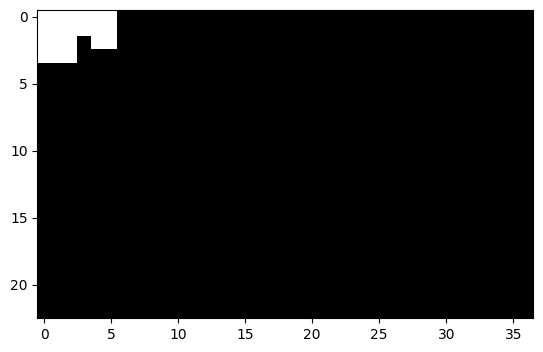

In [23]:
# import and function
import numpy as np
import torch

from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

def deploy_slice(node,width,height):
  #deploy
  if node < 2**(input_per_bin-1):
    state1_[0,node*4] = state1_[0,node*2]
    state1_[0,node*4+1] = state1_[0,node*2+1] - height
    state1_[0,node*4+2] = state1_[0,node*2] -width
    state1_[0,node*4+3] = state1_[0,node*2+1] 
  state1_[0,node*2] = width
  state1_[0,node*2+1] = height
  #calcuate depoly position
  deploy_x = 0
  deploy_y = 0
  current_node = node
  while current_node != 1:
    parent = current_node//2
    LorR = current_node%2
    if LorR == 0: # left tree
      deploy_y += int(state1_[0,parent*2+1])
    else: # right tree
      deploy_x += int(state1_[0,parent*2])
    current_node = parent

  # update
  for check_node in range(1,2**(input_per_bin-1)-1):
    if state1_[0,check_node*2] != -1: # maybe leaf or internal node
      #check left and right, if both is not valid node, this is leaf
      if (state1_[0,check_node*4] == -1 and state1_[0,check_node*4+1] == -1 
        and state1_[0,check_node*4+2] == -1 and state1_[0,check_node*4+3] == -1):
        #find x y axis
        check_node_x = 0
        check_node_y = 0
        current_node = check_node
        while current_node != 1:
          parent = current_node//2
          LorR = current_node%2
          if LorR == 0: # left tree
            check_node_y += int(state1_[0,parent*2+1])
          else: # right tree
            check_node_x += int(state1_[0,parent*2])
          current_node = parent
        # update node size
        # tree node's upper area is covered by new node
        if deploy_x < check_node_x + state1_[0,check_node*2] and deploy_x + width > check_node_x and \
          deploy_y > check_node_y and check_node_y + state1_[0,check_node*2+1] > deploy_y:
          state1_[0,check_node*2+1] = deploy_y - check_node_y
          #print("upper")
        # tree node's right area is covered by new node
        if deploy_y < check_node_y + state1_[0,check_node*2+1] and deploy_y + height > check_node_y and \
          deploy_x > check_node_x and check_node_x + state1_[0,check_node*2] > deploy_x:
          state1_[0,check_node*2] = deploy_x - check_node_x
          #print("right")
        # tree node's lower area is exactly cover by new node
        if deploy_x == check_node_x and \
          deploy_y < check_node_y and deploy_y + height > check_node_y:
          state1_[0,check_node*2] = deploy_x - check_node_x
          #print("lower")
        # adjust node is exactly same x y to the new node
        if deploy_x == check_node_x and deploy_y == check_node_y:
          state1_[0,check_node*2] = 0
          state1_[0,check_node*2+1] = 0

        # prevent both leaf node space's height and width reduce to 0
        # will cause can not check if it is leaf node
        # if state1_[0,check_node*2] == 0 and state1_[0,check_node*2+1] == 0:
        #   state1_[0,check_node*2] = 9
        #   state1_[0,check_node*2+1] = 9

def show_tree():
  newline_num = 1
  tree_end_flag = 0
  for show_index in range(1,2**(input_per_bin)-1):
    if state1_[0,show_index*2] != -1 and state1_[0,show_index*2+1] != -1:
      print(" node",show_index,":",int(state1_[0,show_index*2]),int(state1_[0,show_index*2+1]), end = ',')
      tree_end_flag = 1
    if show_index == newline_num:
      if tree_end_flag == 1:
        tree_end_flag = 0
        print("\n")
      else:
        print("end tree")
        return
      newline_num = newline_num*2 + 1 

def show_tree_file():
  newline_num = 1
  for show_index in range(1,2**(input_per_bin)-1):
    if state1_[0,show_index*2] != -1 and state1_[0,show_index*2+1] != -1:
      with open("show_tree_test.txt", 'a') as f:
        f.write(" node")
        f.write(str(show_index))
        f.write(":")
        f.write(str(int(state1_[0,show_index*2])))
        f.write(" ")
        f.write(str(int(state1_[0,show_index*2+1])))
        f.write(",")
      #print(" node",show_index,":",int(state1_[0,show_index*2]),int(state1_[0,show_index*2+1]), end = ',', file=f)
    if show_index == newline_num:
      #print("\n", file=f)
      with open("show_tree_test.txt", 'a') as f:
        f.write("\n")
      newline_num = newline_num*2 + 1

def tree_to_img():
  tree_img = torch.zeros(bin_w,bin_h)
  newline_num = 1
  tree_end_flag = 0
  
  for show_index in range(1,2**(input_per_bin)-1):
    current_x = 0
    current_y = 0
    #show index is tree node index
    if state1_[0,show_index*2] != -1 and state1_[0,show_index*2+1] != -1:
      if state1_[0,show_index*4] == -1 and state1_[0,show_index*4+1] == -1 and state1_[0,show_index*4+2] == -1 and state1_[0,show_index*4+3] == -1:
        #this is leaf node
        continue
      current_width = int(int(state1_[0,show_index*2])/100)
      current_height = int(int(state1_[0,show_index*2+1])/100)
      #print("show_index",show_index,current_width,current_height)
      #print("current_width current_height type",type(current_width),type(current_height))
      current_index = show_index

      while current_index != 1 :
        parent = current_index//2
        LorR = current_index%2
        if LorR == 0:
          current_y += int(state1_[0,parent*2+1]) / 100
        else:
          current_x += int(state1_[0,parent*2]) / 100
        current_index = parent
      current_x = int(current_x)
      current_y = int(current_y)
      #print("current_x,current_y",current_x,current_y)
      tree_img[current_x:current_x+current_width,current_y:current_y+current_height] = 1
      tree_end_flag = 1
    if show_index == newline_num:
      if tree_end_flag == 1:
        tree_end_flag = 0
        #print("\n")
      else:
        #print("end tree")
        plt.imshow(tree_img,cmap='gray')
        return tree_img
      newline_num = newline_num*2 + 1
  plt.imshow(tree_img,cmap='gray')
  return tree_img

def moving_average(lst, move=5):
    moving_averages = []
    for i in range(len(lst)):
        start_idx = max(0, i - move)
        end_idx = min(i + move + 1, len(lst))
        window = lst[start_idx:end_idx]
        average = sum(window) / len(window)
        moving_averages.append(average)

    return moving_averages

def calculate_surrounded_area():
  max_x = []
  max_y = []
  for check_node in temp_deployed_place:
  #find x y axis
    check_node_x = 0
    check_node_y = 0
    current_node = check_node
    while current_node != 1:
      parent = current_node//2
      LorR = current_node%2
      if LorR == 0: # left tree
        check_node_y += int(state1_[0,parent*2+1])
      else: # right tree
        check_node_x += int(state1_[0,parent*2])
      current_node = parent
      #find right and left range and append to max list
      max_x.append(check_node_x + int(state1_[0,check_node*2]))
      max_y.append(check_node_y + int(state1_[0,check_node*2+1]))
      surrounded_area = max(max_x) * max(max_y)
  
  return surrounded_area

shape = (2**(input_per_bin+1),2,)
tree_tensor = torch.zeros(shape)
state1_ = tree_tensor.reshape(1,2**(input_per_bin+2))
state1_[0,2] = bin_w * 100
state1_[0,3] = bin_h * 100
#print(state1_)

file = open("shuffle_data/full_bin_5_5_100.txt",'r')
content = file.read()
file.close
slices = content.split('\n')
new_slice = slices[0].split()
width = float(new_slice[0])
height = float(new_slice[1])
state1_[0,0] = width
state1_[0,1] = height
# print(state1_)
node = 1
# print(state1_[0,node*2])
if width <= state1_[0,node*2] and height <= state1_[0,node*2+1]:
  state1_[0,node*4] = state1_[0,node*2]
  state1_[0,node*4+1] = state1_[0,node*2+1] - height
  state1_[0,node*4+2] = state1_[0,node*2] -width
  state1_[0,node*4+3] = state1_[0,node*2+1] 
  state1_[0,node*2] = width
  state1_[0,node*2+1] = height
  
#print(state1_[0,node*2],"*",state1_[0,node*2+1])
# print("A: ",state1_,"/n")

tree_tensor = torch.ones(shape) * -1
state1_ = tree_tensor.reshape(1,2**(input_per_bin+2))
state1_[0,2] = bin_w*100
state1_[0,3] = bin_h*100
#print(state1_)

slices = content.split('\n')
new_slice = slices[0].split()
width = float(new_slice[0])
height = float(new_slice[1])
state1_[0,0] = width
state1_[0,1] = height
#print(state1_)
node = 1
if width <= state1_[0,node*2] and height <= state1_[0,node*2+1]:
  deploy_slice(node,width,height)

#print(state1_[0,node*2],"*",state1_[0,node*2+1])
#print("B: ",state1_,"/n")

node = 31
state1_[0,node*2] = 100
state1_[0,node*2+1] = 400
width_3 = 100
height_3 = 300
#if width <= state1_[0,node*2] and height <= state1_[0,node*2+1]:
deploy_slice(node,width_3,height_3)

#print(state1_[0,node*4],"*",state1_[0,node*4+1],",",state1_[0,node*4+2],"*",state1_[0,node*4+3])
#print("c: ",state1_,"/n")

# try update
print("try update\n")
tree_tensor = torch.ones(shape) *-1
state1_ = tree_tensor.reshape(1,2**(input_per_bin+2))
state1_[0,2] = 600
state1_[0,3] = 1000
print(state1_)      

deploy_slice(1,200,200)
#show_tree()
tree_to_img()

deploy_slice(2,200,200)
#show_tree()
tree_to_img()


deploy_slice(3,200,200)
#show_tree()

deploy_slice(4,300,200)
#show_tree()
tree_to_img()

deploy_slice(6,200,100)
show_tree()
tree_to_img()

deployed_place = []
deployed_place.append(1)
deployed_place.append(2)
deployed_place.append(3)
deployed_place.append(5)
temp_deployed_place = copy.deepcopy(deployed_place)
max_x = []
max_y = []
for check_node in deployed_place:
  #find x y axis
  check_node_x = 0
  check_node_y = 0
  current_node = check_node
  while current_node != 1:
    parent = current_node//2
    LorR = current_node%2
    if LorR == 0: # left tree
      check_node_y += int(state1_[0,parent*2+1])
    else: # right tree
      check_node_x += int(state1_[0,parent*2])
    current_node = parent
  #find right and left range and append to max list
  max_x.append(check_node_x + int(state1_[0,check_node*2]))
  max_y.append(check_node_y + int(state1_[0,check_node*2+1]))
surrounded_area = max(max_x) * max(max_y)
print("1.",surrounded_area)
max_x = []
max_y = []
for check_node in temp_deployed_place:
  #find x y axis
  check_node_x = 0
  check_node_y = 0
  current_node = check_node
  while current_node != 1:
    parent = current_node//2
    LorR = current_node%2
    if LorR == 0: # left tree
      check_node_y += int(state1_[0,parent*2+1])
    else: # right tree
      check_node_x += int(state1_[0,parent*2])
    current_node = parent
  #find right and left range and append to max list
  max_x.append(check_node_x + int(state1_[0,check_node*2]))
  max_y.append(check_node_y + int(state1_[0,check_node*2+1]))
surrounded_area = max(max_x) * max(max_y)
print("2.",surrounded_area)
ans = calculate_surrounded_area()
print("ans:",ans)
#print(max_x)
#print(max_y)
#print(surrounded_area)


tree_file = open("tree.txt",'w')
#show_tree_file()

In [24]:
#test bin size adjust
bin_w = 23
bin_h = 37
input_per_bin = 12


print("now test size = ",bin_w,bin_h)


now test size =  23 37


In [25]:
# target model test
from collections import deque
import random
import os
#delete output file last time
try:
    os.remove("result_test.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("show_tree_test.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

#get all slice info
#file = open("slice_data/full_bin_" + str(bin_w) + "_" + str(bin_h) + "_100.txt",'r')
file = open("shuffle_data/full_bin_" + str(bin_w) + "_" + str(bin_h) + "_100.txt",'r')
#file = open("0615_data/full_bin_s_" + str(bin_w) + "_" + str(bin_h) + "_10.txt",'r')

content = file.read()
file.close
slices = content.split('\n')
#print(slices)
if slices[-1] == "":
    print("empty")
    slices.pop()

#training setting

test_epochs = 100
shape = (2**(input_per_bin+1),2,)
test_rewards = []
tree_imgs = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)

h = 0
#initial state
input_count = 0
tree_tensor = torch.ones(shape) * -1
state1_ = tree_tensor.reshape(1,2**(input_per_bin+2))
state1_[0,2] = bin_w * 100 #預設寬600 高1000
state1_[0,3] = bin_h * 100
epsilon = 0
tree_count = 0
total_accept_test = 0
total_area_test = 0
PE_per_board_test = []
accept_prob_per_board_test = []
deployed_place = []
for i in range(test_epochs):    
    #if(i%48 == 0):  #clear board
    #random.shuffle(slices)
    do_clear = 0
    tree_tensor = torch.ones(shape) * -1
    state1_ = tree_tensor.reshape(1,2**(input_per_bin+2))
    state1_[0,2] = bin_w * 100 #預設寬600 高1000
    state1_[0,3] = bin_h * 100
    status = 1
    input_count = 0
    total_area_test = 0
    accepted_count = 0
    deployed_place = []
    while(status == 1): #1 board
      #set state        
      new_slice = slices[input_per_bin*i+input_count].split()
      width = new_slice[0]
      height = new_slice[1]
      state1_[0,0] = float(width)
      state1_[0,1] = float(height)
      input_count += 1
      #store original data
      temp_state1_ = state1_
      temp_deployed_place = copy.deepcopy(deployed_place)
      #find valid place
      valid_place = []
      valid_place_count = 0
      

      for node in range(1,2**(input_per_bin)):          
        if state1_[:,node*2] > 0 and state1_[:,node*2+1] > 0:
          if(state1_[:,node*4] == -1 and state1_[:,node*4+1] == -1  #left undefined
            and state1_[:,node*4+2] == -1 and state1_[:,node*4+3] == -1 #right undefined
            and state1_[:,node*2] >= state1_[0,0] and state1_[:,node*2+1] >= state1_[0,1]): #space enough
            valid_place.append(node)
            valid_place_count += 1
         

      #select action
      if valid_place_count != 0:
        if(accepted_count == 0):
          action_ = 1 #root
          with open("result_test.txt", 'a') as f:
            f.write("epoch:")
            f.write(str(i*12+input_count+1))
            f.write(" start:")
            f.write(str(action_))
            f.write(" ") 
        else:
          #Q:choose max Q in valid place
          surrounded_area_each = []
          for choice in range(valid_place_count):
            temp_deployed_place = copy.deepcopy(deployed_place)
            temp_deployed_place.append(valid_place[choice])
            surrounded_area_each.append(calculate_surrounded_area())
          min_surrounded_area = min(surrounded_area_each)
          #print(max_Q)
          #print(valid_Q.index(max_Q))
          #print(valid_place[valid_Q.index(max_Q)])
          action_ = valid_place[surrounded_area_each.index(min_surrounded_area)]

          with open("result_test.txt", 'a') as f:
            f.write("epoch:")
            f.write(str(i+1))
            f.write(" Q:\t")
            f.write(str(action_))
            f.write(" ")

        
    

      with open("result_test.txt", 'a') as f:
        f.write(str(width))
        f.write("x")
        f.write(str(height))
        f.write("\n")
      
    
      if valid_place_count != 0:
        accepted_count += 1
        total_accept_test += 1
        total_area_test = total_area_test + float(width)*float(height)
        deploy_slice(action_, float(width), float(height))
        deployed_place.append(action_)

      with open("show_tree_test.txt", 'a') as f:
          f.write("test episode: ")
          f.write(str(i+1))
          f.write(" step: ")
          f.write(str(input_count))
          f.write(" width,height: ")
          f.write(str(width))
          f.write(",")
          f.write(str(height))
          
          f.write(str(valid_place))
          f.write(" action: ")
          f.write(str(action_))
          f.write("\n")
      show_tree_file()
        
      if input_count == input_per_bin:
        accept_prob_per_board_test.append(accepted_count/input_per_bin)
        PE_per_board_test.append(total_area_test/(bin_w*bin_h*10000))
        status = 0 #one board done, exit while and clear board

        #this_tree_img = tree_to_img()
        #tree_imgs.append(this_tree_img)

        
        with open("result_test.txt", 'a') as f:
          f.write("clear\n")

      
      print("episode:",i)
      clear_output(wait=True)
    if epsilon > 0.1:
      epsilon -= (1/test_epochs)
        
print(str(bin_w) + "*" + str(bin_h) + str(test_epochs) + " episodes test finished.")

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network
#print("total accept rate: ",total_accept/(100*12))


23*37100 episodes test finished.


total accept rate:  0.905
average PE:  0.8075558166862515


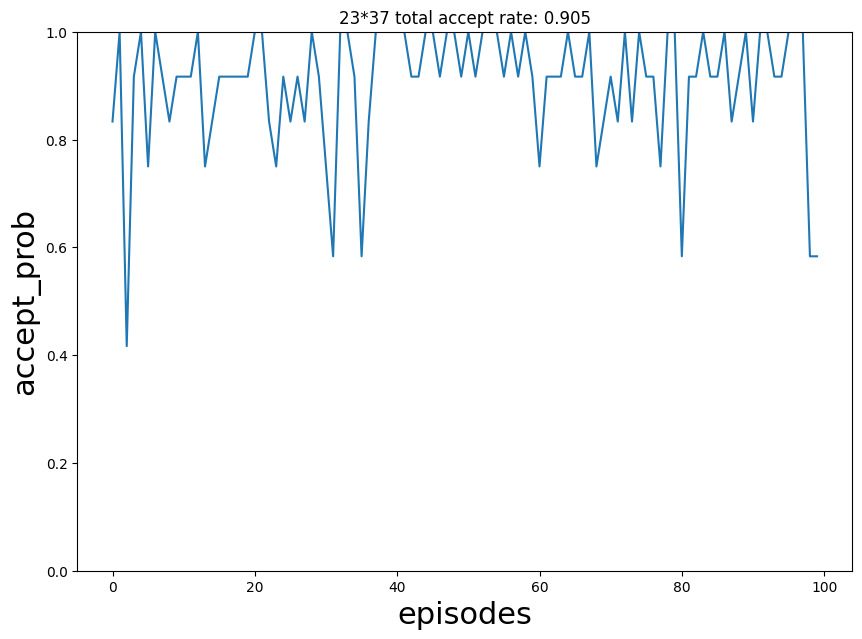

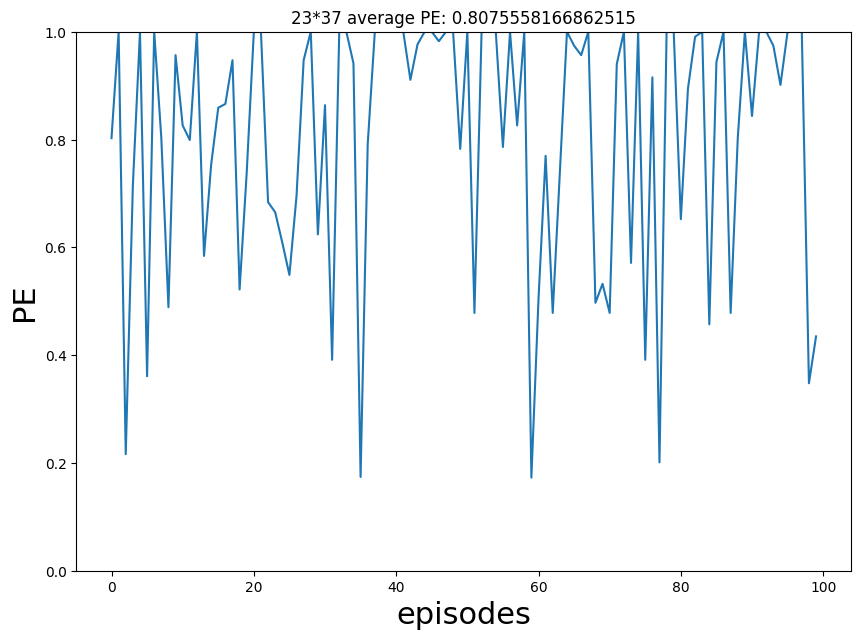

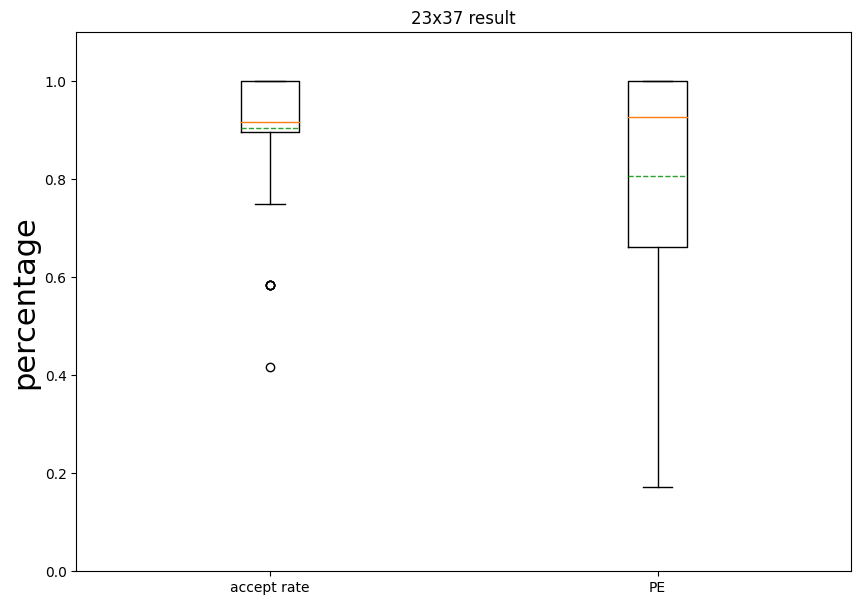

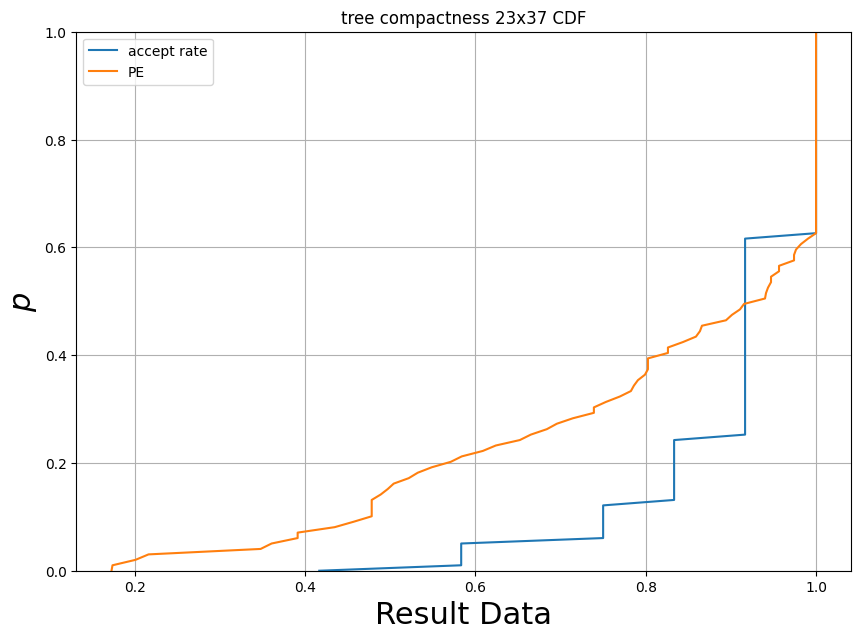

In [26]:
string_accept_prob_per_board_test = str(bin_w) + "*" + str(bin_h) + " total accept rate: " + str(total_accept_test/(test_epochs*input_per_bin))
string_PE_per_board_test = str(bin_w) + "*" + str(bin_h) + " average PE: " +str(sum(PE_per_board_test) / len(PE_per_board_test))

#accept rate plot
plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.plot(accept_prob_per_board_test)
plt.title(string_accept_prob_per_board_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("accept_prob",fontsize=22) 
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_accept_prob_per_board.png",dpi=300)

#PE plot
plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.title(string_PE_per_board_test)
plt.plot(PE_per_board_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("PE",fontsize=22)
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_PE_per_board.png",dpi=300)

#box plot
plt.figure(figsize=(10,7))
plt.ylim(0,1.1)
x_labels = "accept rate","PE"
plt.boxplot([accept_prob_per_board_test,PE_per_board_test], labels = x_labels, showfliers=True,showmeans = True, meanline = True)
plt.title(str(bin_w) + "x" + str(bin_h) + " result")
plt.ylabel("percentage",fontsize=22) 
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_box.png",dpi=300)

#CDF plot
sorted_accept_prob_per_board_test = copy.deepcopy(accept_prob_per_board_test)
sorted_accept_prob_per_board_test.sort() #sort small to big
p1 = 1. * np.arange(len(sorted_accept_prob_per_board_test)) / (len(sorted_accept_prob_per_board_test) - 1) # calculate the proportional values of samples
sorted_PE_per_board_test = copy.deepcopy(PE_per_board_test)
sorted_PE_per_board_test.sort()
p2 = 1. * np.arange(len(sorted_PE_per_board_test)) / (len(sorted_PE_per_board_test) - 1)

plt.figure(figsize=(10,7))
plt.ylim(0,1)
plt.title("tree compactness " + str(bin_w) + "x" + str(bin_h) + " CDF")
plt.plot(sorted_accept_prob_per_board_test, p1)
plt.plot(sorted_PE_per_board_test, p2)
plt.legend(['accept rate','PE']) #mark line's name
plt.xlabel("Result Data", fontsize=22)
plt.ylabel("$p$", fontsize=22)
plt.grid(True)
plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_CDF.png",dpi=300)

print("total accept rate: ",total_accept_test/(100*input_per_bin))
print("average PE: ",sum(PE_per_board_test) / len(PE_per_board_test))

import csv
#save data to csv
test_data = zip(["test accept rate"] + accept_prob_per_board_test , ["test PE"] + PE_per_board_test)
test_data = list(test_data)
np.savetxt(dir_name + date_string + "_test_" + str(bin_w) + "x" + str(bin_h) + ".csv",test_data, delimiter =", ", fmt ='% s')

In [27]:
# sorted_accept_prob_per_board_test = copy.deepcopy(accept_prob_per_board_test)
# sorted_accept_prob_per_board_test.sort()
# p1 = 1. * np.arange(len(sorted_accept_prob_per_board_test)) / (len(sorted_accept_prob_per_board_test) - 1)


# sorted_PE_per_board_test = copy.deepcopy(PE_per_board_test)
# sorted_PE_per_board_test.sort()
# p2 = 1. * np.arange(len(sorted_PE_per_board_test)) / (len(sorted_PE_per_board_test) - 1)


# plt.figure(figsize=(10,7))
# plt.ylim(0,1)
# plt.title("compactness CDF")
# plt.plot(sorted_accept_prob_per_board_test, p1)
# plt.plot(sorted_PE_per_board_test, p2)
# plt.legend(['accept rate','PE'])
# plt.xlabel("$x$")
# plt.ylabel("$p$")
# plt.savefig(dir_name + date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_CDF.png",dpi=300)
# #plt.show()



In [28]:
# string_accept_prob_per_board_test = str(bin_w) + "*" + str(bin_h) + " total accept rate: " + str(total_accept_test/(test_epochs*input_per_bin))
# string_PE_per_board_test = str(bin_w) + "*" + str(bin_h) + " average PE: " +str(sum(PE_per_board_test) / len(PE_per_board_test))


# plt.figure(figsize=(10,7))
# plt.ylim(0,1.1)
# x_labels = "accept rate","PE"
# plt.boxplot([accept_prob_per_board_test,PE_per_board_test], labels = x_labels, showfliers=True,showmeans = True, meanline = True)
# plt.title("compare")
# plt.ylabel("accept_prob",fontsize=22) 
# plt.savefig(date_string + "_" + str(bin_w) + "x" + str(bin_h) + "_test_accept_prob_per_board_box.png",dpi=300)

In [29]:
# import csv
# print(torch.seed())
# #print(accept_prob_per_board_test)



# train_data = zip(["training reward"]+rewards,["train accept rate"] + accept_prob_per_board, ["train PE"]+ PE_per_board)
# train_data = list(train_data)
# #print(train_data)
# np.savetxt("train.csv",train_data, delimiter =", ", fmt ='% s')


# test_data = zip(["test accept rate"] + accept_prob_per_board_test , ["test PE"] + PE_per_board_test)
# test_data = list(test_data)
# print(test_data)
# np.savetxt("test.csv",test_data, delimiter =", ", fmt ='% s')

In [30]:
#plt.imshow(tree_imgs[12],cmap='gray')